In [5]:
# 1) Installa engine Excel e Matplotlib
import micropip
await micropip.install(["openpyxl", "matplotlib"])

# 2) Librerie
import pandas as pd
import matplotlib.pyplot as plt

# 3) Leggi il foglio “CAUSALI A MANO” (header sulla seconda riga)
df = pd.read_excel(
    "ANALISI CAUSALI OEE.xlsx",
    sheet_name="CAUSALI A MANO",
    header=1
)

# 4) Dai un’occhiata rapida ai dati
print("Sheet caricato:", df.shape, "righe×colonne")
df.head()


Sheet caricato: (88, 11) righe×colonne


,Unnamed: 0,GG,SETT,GIORNO,POSTAZIONE,OPERATORE,CAUSALE,TEMPO ANNOTATO [min],DIFF,(FORSE) COMPRESO IN,CAUSALI POSTAZIONE
0,NaN,lun,6,2025-02-03,100,719,RIFORNIMENTO MORSETTIERA,15,NaN,NaN,NaN
1,NaN,lun,6,2025-02-03,100,714,PREPARAZIONE SCHEDE E CASSA NUOVA,15,NaN,5700,NaN
2,NaN,lun,6,2025-02-03,110,714,RIBATTUTO RACCORDO MINIFGX,10,NaN,NaN,NaN
3,NaN,lun,6,2025-02-03,110,714,RUBINETTO MANOMETRO DIFETTATO,10,NaN,NaN,NaN
4,NaN,lun,6,2025-02-03,110,59,NON ARRIVA CORRENTE,30,NaN,NaN,NaN


In [6]:
# 5) Informazioni generali
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            0 non-null      float64       
 1   GG                    81 non-null     object        
 2   SETT                  88 non-null     int64         
 3   GIORNO                86 non-null     datetime64[ns]
 4   POSTAZIONE            88 non-null     int64         
 5   OPERATORE             88 non-null     int64         
 6   CAUSALE               88 non-null     object        
 7   TEMPO ANNOTATO [min]  79 non-null     object        
 8   DIFF                  2 non-null      float64       
 9   (FORSE) COMPRESO IN   10 non-null     object        
 10  CAUSALI POSTAZIONE    4 non-null      object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 5.9+ KB


In [7]:
# 6) Statistiche descrittive su “TEMPO ANNOTATO [min]”
df['TEMPO ANNOTATO [min]'].describe()


count     79
unique    13
top       10
freq      27
Name: TEMPO ANNOTATO [min], dtype: int64

In [9]:
# --- CELL: pulizia colonne e conversione in numerico ---
# verifica prima come si chiamano esattamente le colonne
print(df.columns.tolist())

# rimuovo spazi bianchi per sicurezza
df.columns = df.columns.str.strip()

# converto in numerico (tutto ciò che non si riesce a convertire diventa NaN)
df['TEMPO ANNOTATO [min]'] = pd.to_numeric(df['TEMPO ANNOTATO [min]'], errors='coerce')

# se vuoi, sostituisci NaN con zero
df['TEMPO ANNOTATO [min]'] = df['TEMPO ANNOTATO [min]'].fillna(0).astype(int)

# controlla il tipo
print(df['TEMPO ANNOTATO [min]'].dtype)


['Unnamed: 0', 'GG', 'SETT', 'GIORNO', 'POSTAZIONE', 'OPERATORE', 'CAUSALE', 'TEMPO ANNOTATO [min]', 'DIFF', '(FORSE) COMPRESO IN', 'CAUSALI POSTAZIONE']
int32


In [10]:
# 7) Tempo totale per ciascuna CAUSALE
cause_summary = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)
cause_summary


CAUSALE
ASPIRAZIONE CENTRALINE E SISTEMAZIONE CARRELLI    125
ASSEMBLEA                                         120
RIFORNIMENTO LINEA                                115
PROBLEMA VIBRAZIONE IN DISCESA                     90
AIUTATO                                            70
PULIZIE                                            65
PULIZIA CENTRALINE POST COLLAUDO                   65
PREPARAZIONE SCHEDE E CASSA NUOVA                  60
SOSTITUZIONE CASSONI                               60
CONTROLLO RECUPERO                                 40
SINDACATO                                          40
APPROVVIGIONAMENTO MATERIALE                       40
PULIZIA POSTAZIONE                                 30
RIFORNIMENTO BANCHETTO                             30
COLLOQUIO                                          30
PULIZIA E RIFORNIMENTO                             30
RIFORNIMENTO TAVOLO                                30
NON ARRIVA CORRENTE                                30
SMONTAGGIO HSV E SVU

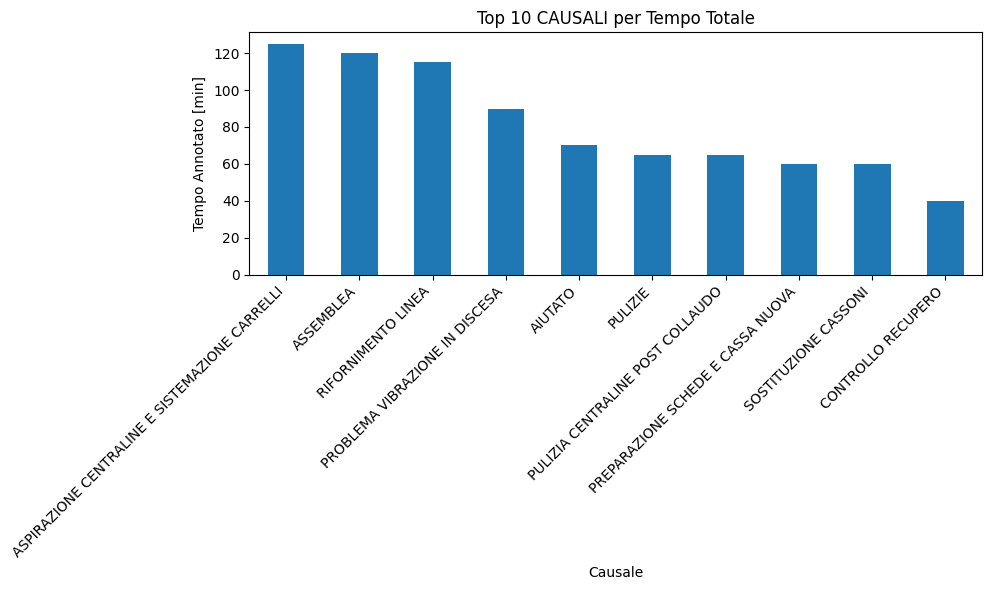

In [11]:
# 2) Calcolo tempo totale per ciascuna causa e selezione top 10
cause_summary = (
    df
    .groupby('CAUSALE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)
top10 = cause_summary.head(10)

# 3) Grafico a barre
plt.figure(figsize=(10, 6))
top10.plot(kind='bar')
plt.title('Top 10 CAUSALI per Tempo Totale')
plt.xlabel('Causale')
plt.ylabel('Tempo Annotato [min]')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

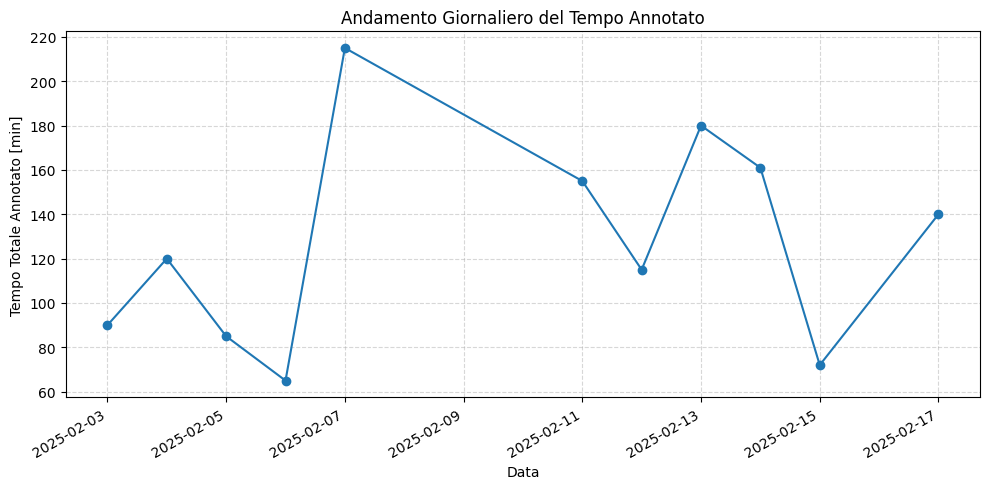

In [12]:
# 2) Convertiamo 'GIORNO' in datetime (formato gg/mm/aaaa o simile)
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True)

# 3) Sommiamo il tempo annotato per ciascun giorno
daily_totals = (
    df
    .groupby('GIORNO')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_index()
)

# 4) Plottiamo l’andamento giornaliero
plt.figure(figsize=(10, 5))
daily_totals.plot(kind='line', marker='o')
plt.title('Andamento Giornaliero del Tempo Annotato')
plt.xlabel('Data')
plt.ylabel('Tempo Totale Annotato [min]')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

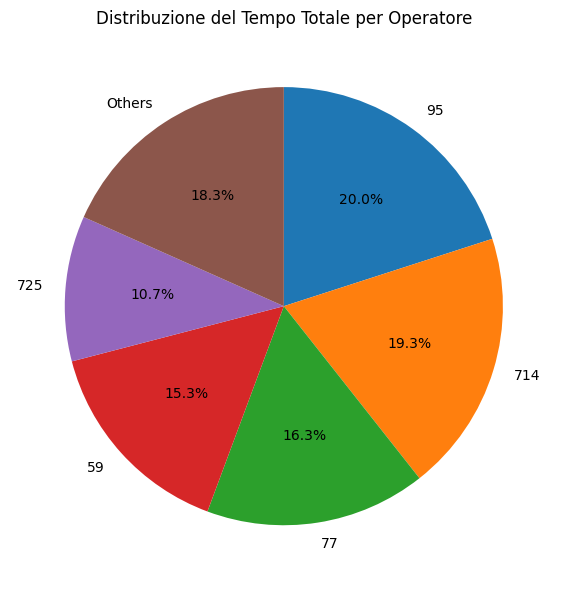

In [13]:
# 2) Calcolo tempo totale per ciascun operatore
op_summary = (
    df
    .groupby('OPERATORE')['TEMPO ANNOTATO [min]']
    .sum()
    .sort_values(ascending=False)
)

# 3) Prendo i primi 5 operatori e raggruppo gli altri in “Others”
top5 = op_summary.head(5).copy()
others = op_summary.iloc[5:].sum()
top5['Others'] = others

# 4) Pie chart
plt.figure(figsize=(6,6))
top5.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('Distribuzione del Tempo Totale per Operatore')
plt.ylabel('')         # togliamo la label y
plt.tight_layout()
plt.show()

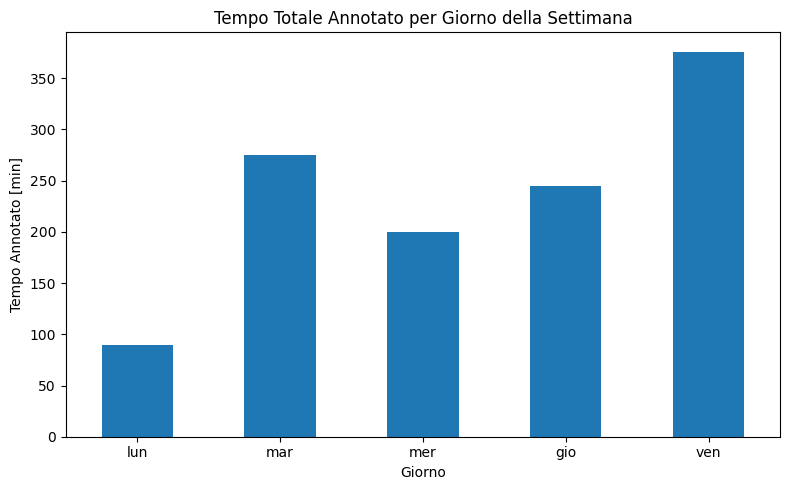

In [14]:
# 2) Somma per giorno della settimana (GG)
#    Assicuriamoci di ordinarli lun-mar-mer-gio-ven
order = ['lun', 'mar', 'mer', 'gio', 'ven']
time_by_weekday = (
    df
    .groupby('GG')['TEMPO ANNOTATO [min]']
    .sum()
    .reindex(order)
)

# 3) Grafico a barre verticali
plt.figure(figsize=(8, 5))
time_by_weekday.plot(kind='bar')
plt.title('Tempo Totale Annotato per Giorno della Settimana')
plt.xlabel('Giorno')
plt.ylabel('Tempo Annotato [min]')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

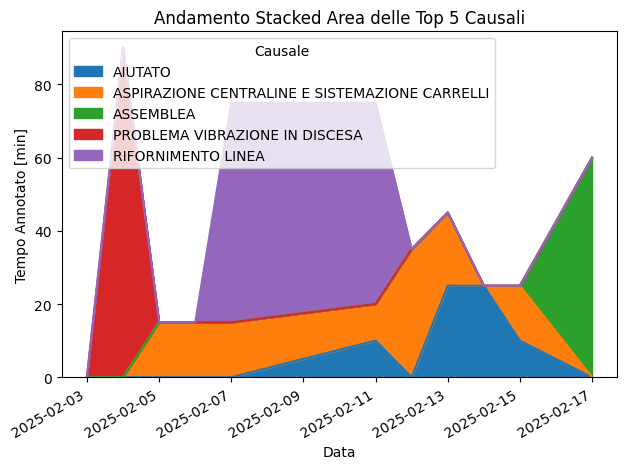

In [15]:
df['GIORNO'] = pd.to_datetime(df['GIORNO'], dayfirst=True)

# 2) Trova le top 5 causali per volume totale
cause_tot = df.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum()
top5 = cause_tot.nlargest(5).index.tolist()

# 3) Pivot giornaliero per causale (teniamo solo le top5)
daily = (
    df[df['CAUSALE'].isin(top5)]
    .pivot_table(
        index='GIORNO',
        columns='CAUSALE',
        values='TEMPO ANNOTATO [min]',
        aggfunc='sum',
        fill_value=0
    )
    .sort_index()
)

# 4) Stacked area plot
plt.figure(figsize=(12, 6))
daily.plot.area()
plt.title('Andamento Stacked Area delle Top 5 Causali')
plt.xlabel('Data')
plt.ylabel('Tempo Annotato [min]')
plt.legend(title='Causale', loc='upper left')
plt.tight_layout()
plt.show()

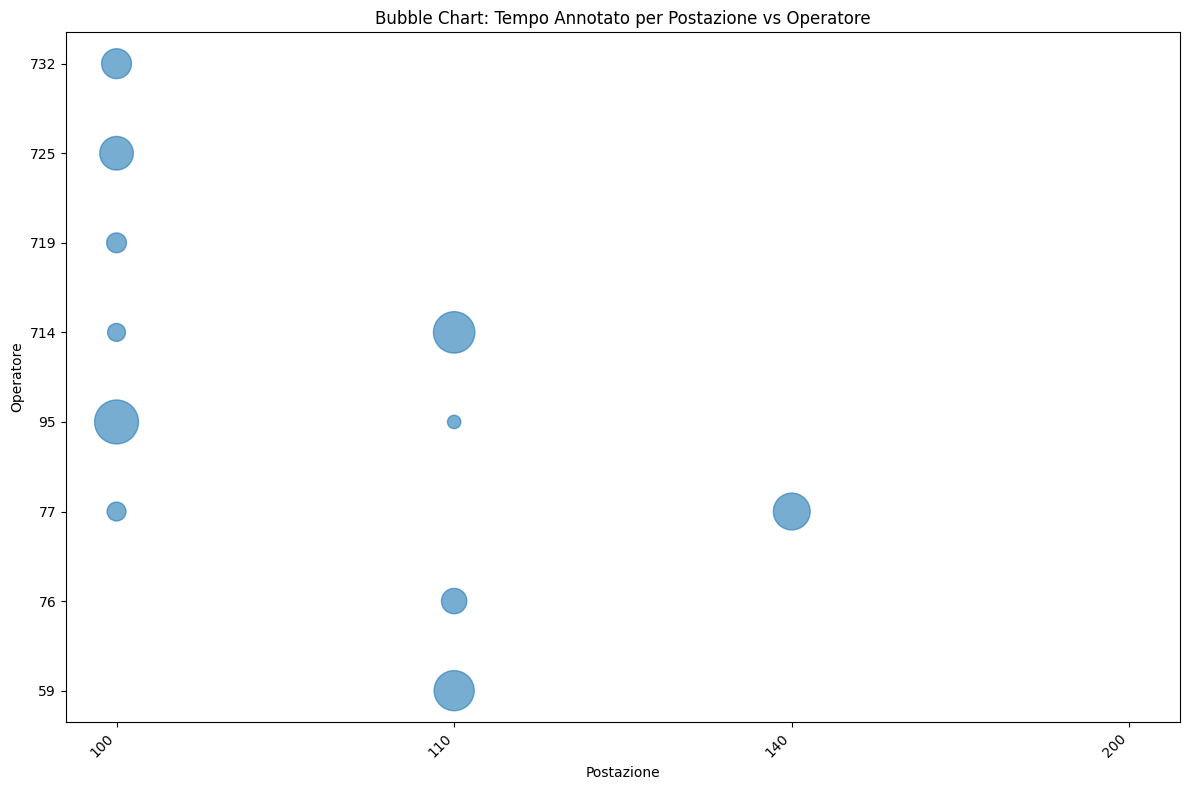

In [16]:

# 2) Aggrega per Postazione e Operatore
agg = (
    df
    .groupby(['POSTAZIONE', 'OPERATORE'])['TEMPO ANNOTATO [min]']
    .sum()
    .reset_index()
)

# 3) Mappa categorie a indici numerici
agg['post_idx'] = agg['POSTAZIONE'].astype('category').cat.codes
agg['op_idx'] = agg['OPERATORE'].astype('category').cat.codes

# 4) Scala dimensioni bolle
max_time = agg['TEMPO ANNOTATO [min]'].max()
agg['size'] = agg['TEMPO ANNOTATO [min]'] / max_time * 1000

# 5) Disegna il bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(agg['post_idx'], agg['op_idx'], s=agg['size'], alpha=0.6)
plt.xticks(
    ticks=range(len(agg['POSTAZIONE'].unique())),
    labels=agg['POSTAZIONE'].astype('category').cat.categories,
    rotation=45, ha='right'
)
plt.yticks(
    ticks=range(len(agg['OPERATORE'].unique())),
    labels=agg['OPERATORE'].astype('category').cat.categories
)
plt.xlabel('Postazione')
plt.ylabel('Operatore')
plt.title('Bubble Chart: Tempo Annotato per Postazione vs Operatore')
plt.tight_layout()
plt.show()

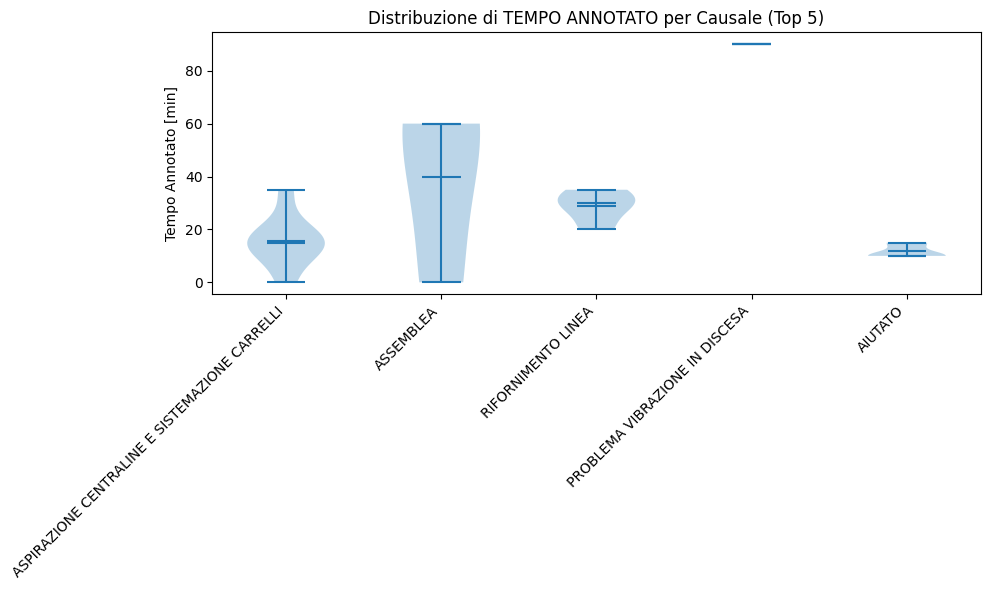

In [17]:

# 2) Seleziona le top 5 causali per tempo totale
cause_tot = df.groupby('CAUSALE')['TEMPO ANNOTATO [min]'].sum()
top5 = cause_tot.nlargest(5).index.tolist()

# 3) Prepara i dati per il violin plot
data = [df[df['CAUSALE'] == c]['TEMPO ANNOTATO [min]'] for c in top5]

# 4) Disegna il violin plot
plt.figure(figsize=(10, 6))
plt.violinplot(data, showmeans=True, showmedians=True)
plt.xticks(range(1, len(top5) + 1), top5, rotation=45, ha='right')
plt.title('Distribuzione di TEMPO ANNOTATO per Causale (Top 5)')
plt.ylabel('Tempo Annotato [min]')
plt.tight_layout()
plt.show()

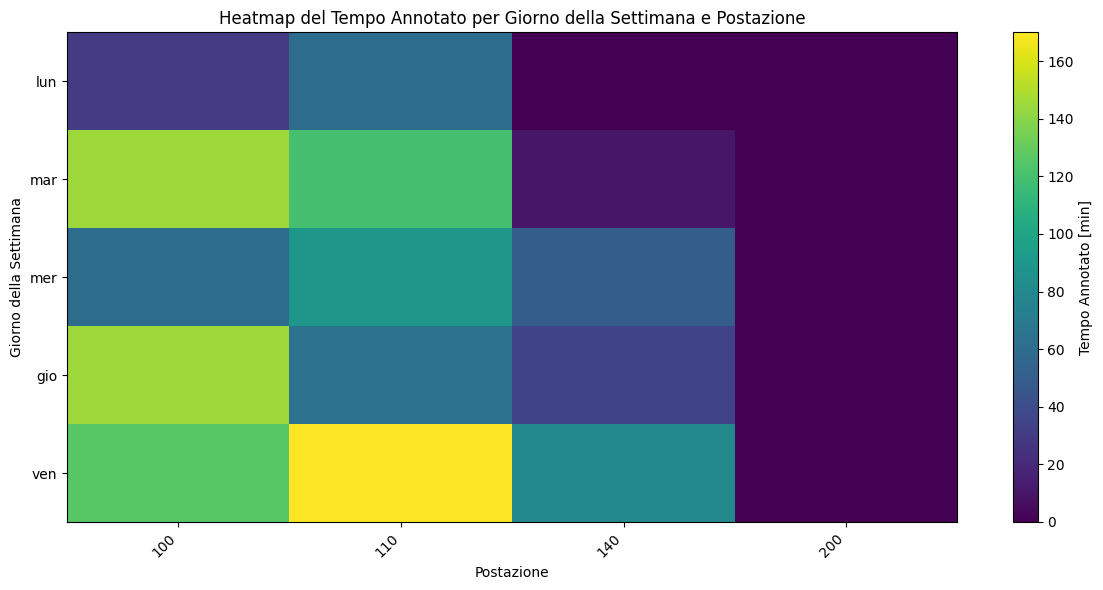

In [18]:

# 2) Prepara la heatmap: somma per Giorno della Settimana (GG) e Postazione
df['GG'] = df['GG'].str.strip()
order = ['lun', 'mar', 'mer', 'gio', 'ven']
heatmap_data = (
    df
    .groupby(['GG', 'POSTAZIONE'])['TEMPO ANNOTATO [min]']
    .sum()
    .unstack(fill_value=0)
    .reindex(index=order)
)

# 3) Disegna la heatmap
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(heatmap_data.values, aspect='auto')

# Etichette assi
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
ax.set_yticks(range(len(order)))
ax.set_yticklabels(order)

# Titoli
ax.set_xlabel('Postazione')
ax.set_ylabel('Giorno della Settimana')
ax.set_title('Heatmap del Tempo Annotato per Giorno della Settimana e Postazione')

# Colorbar
cbar = fig.colorbar(im, ax=ax, label='Tempo Annotato [min]')

plt.tight_layout()
plt.show()

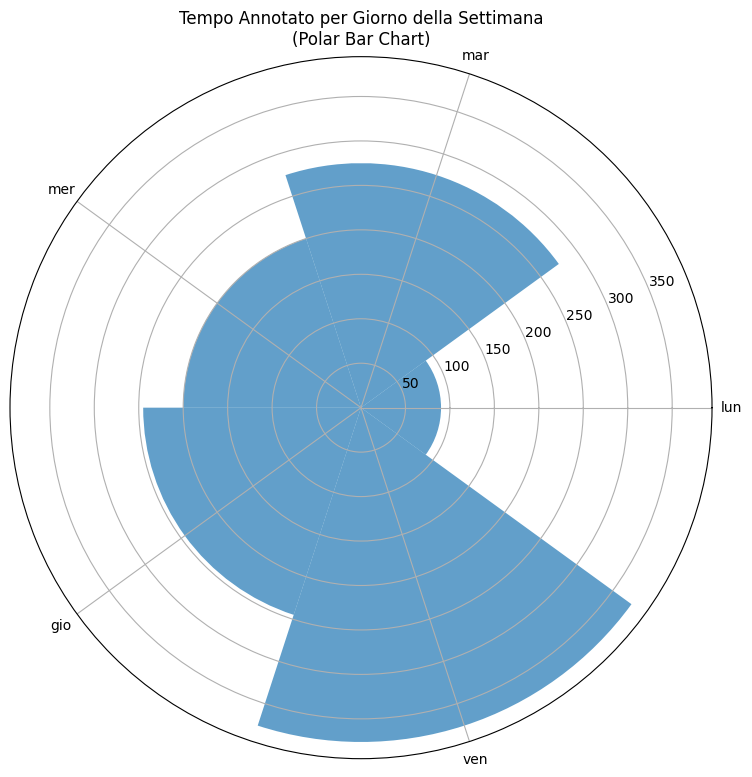

In [20]:
import numpy as np 

# 2) Somma del tempo per giorno della settimana
df['GG'] = df['GG'].str.strip()
order = ['lun', 'mar', 'mer', 'gio', 'ven']
time_by_weekday = (
    df
    .groupby('GG')['TEMPO ANNOTATO [min]']
    .sum()
    .reindex(order)
)

# 3) Preparo angoli e raggi per il polar bar chart
N = len(order)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
radii = time_by_weekday.values
width = 2 * np.pi / N

# 4) Disegna il polar bar chart
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='polar')
bars = ax.bar(angles, radii, width=width, bottom=0, alpha=0.7)

# 5) Etichette e titolo
ax.set_xticks(angles)
ax.set_xticklabels(order)
ax.set_title('Tempo Annotato per Giorno della Settimana\n(Polar Bar Chart)', va='bottom')

plt.tight_layout()
plt.show()

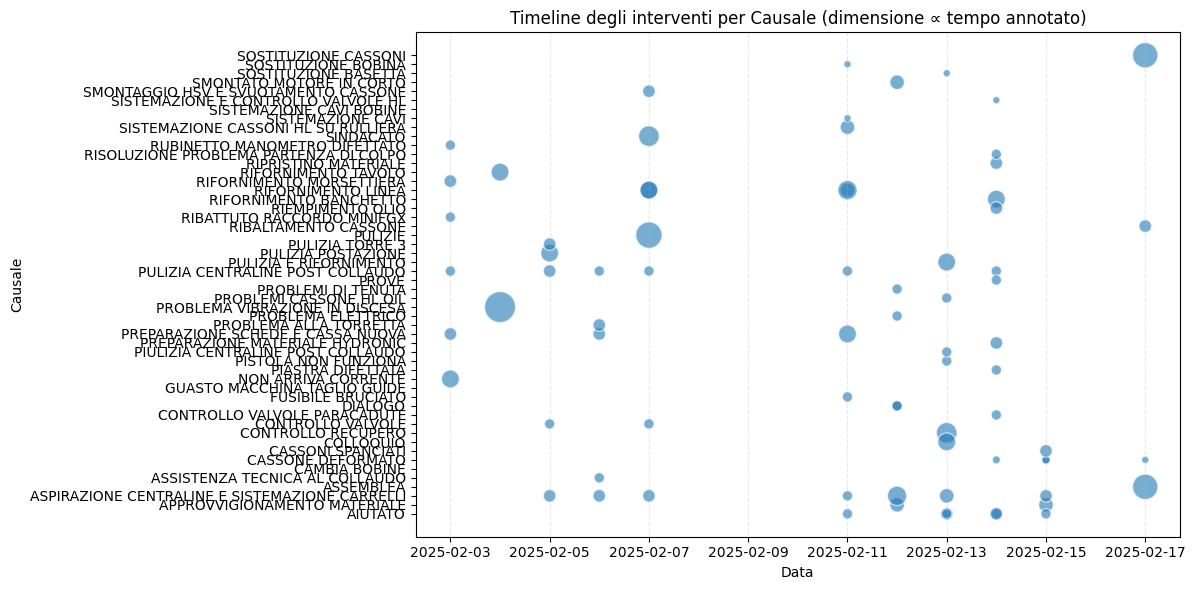

In [21]:
# 2) Mappa le causali su un asse numerico
df['cause_idx'] = df['CAUSALE'].astype('category').cat.codes
cause_labels = df['CAUSALE'].astype('category').cat.categories

# 3) Scala la dimensione delle bolle
max_t = df['TEMPO ANNOTATO [min]'].max()
df['bubble_size'] = df['TEMPO ANNOTATO [min]'] / max_t * 500  # scala fino a ~500 punti

# 4) Scatter timeline
plt.figure(figsize=(12, 6))
plt.scatter(
    df['GIORNO'], 
    df['cause_idx'], 
    s=df['bubble_size'], 
    alpha=0.6, 
    edgecolors='w'
)
plt.yticks(ticks=range(len(cause_labels)), labels=cause_labels)
plt.xlabel('Data')
plt.ylabel('Causale')
plt.title('Timeline degli interventi per Causale (dimensione ∝ tempo annotato)')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

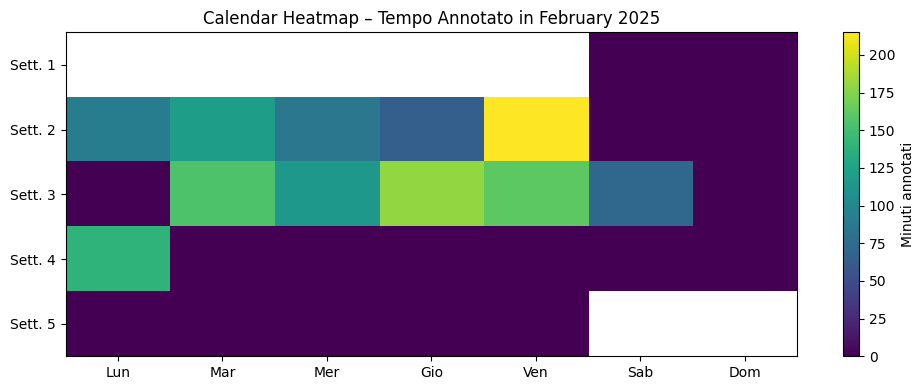

In [22]:
import calendar


# 2) Totali giornalieri
daily_totals = df.groupby('GIORNO')['TEMPO ANNOTATO [min]'].sum()

# 3) Costruisci la “calendar matrix” per il mese
year = daily_totals.index.year.unique()[0]
month = daily_totals.index.month.unique()[0]
cal = calendar.monthcalendar(year, month)

# 4) Popola la matrice con i valori, NaN per i giorni fuori mese
mat = np.full((len(cal), 7), np.nan)
for week_i, week in enumerate(cal):
    for day_i, day in enumerate(week):
        if day != 0:
            date = pd.Timestamp(year, month, day)
            mat[week_i, day_i] = daily_totals.get(date, 0)

# 5) Visualizzazione heatmap “calendario”
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(mat, aspect='auto')

# etichette asse X (giorni)
ax.set_xticks(range(7))
ax.set_xticklabels(['Lun','Mar','Mer','Gio','Ven','Sab','Dom'])
# etichette asse Y (settimane)
ax.set_yticks(range(len(cal)))
ax.set_yticklabels([f'Sett. {i+1}' for i in range(len(cal))])

ax.set_title(f'Calendar Heatmap – Tempo Annotato in {calendar.month_name[month]} {year}')
cbar = plt.colorbar(im, ax=ax, label='Minuti annotati')

plt.tight_layout()
plt.show()